## Alanine Dipeptide

In [1]:
root_path = '~/local/OPES-explore/ala2/'

In [2]:
import numpy as np
try: # if pandas is available use it to load files, since it is much faster
    import pandas
    def loadfile(fname, unpack=False, delimiter='\s+', comment='#', dtype=float, skiprows=None, usecols=None):
        data = pandas.read_table(fname, header=None, sep=delimiter, comment=comment, dtype=dtype, skiprows=skiprows, usecols=usecols).to_numpy()
        if unpack == True:
            return (data[:,i] for i in range(data.shape[-1]))
        else:
            return data
except:
    print('+++ pandas not found: loading files will be slower +++')
    loadfile = np.loadtxt

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection
try:
    import fessa
    plt.set_cmap('fessa')
except:
    pass

<Figure size 432x288 with 0 Axes>

In [4]:
#set bigger font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16

plt.rc('font', size=SMALL_SIZE)        # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)   # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)   # fontsize of the figure title

In [5]:
kB = 0.008314462618153239
temp = 300
kbt = kB*temp
gamma = 30/kbt
max_fes = 40/kbt
stride = 100
rasterization = True

kernels_expl = loadfile(root_path+'explore/STATE')
kernels_opes = loadfile(root_path+'opes/STATE')

In [6]:
def add_ellipses(ax, kernels, scale, add_images=True, dx=0, dy=0):
    pc = PatchCollection([ Ellipse(xy=(ker[1]-dx,ker[2]-dy), width=ker[3], height=ker[4]) for ker in kernels ])
    pc.set_array(np.minimum(max_fes, -scale*np.log(kernels[:,5]/max(kernels[:,5]))))
    pc.set_clim((0, max_fes))
    pc.set_rasterized(rasterization)
    ax.add_collection(pc)
    if add_images:
        period = 2*np.pi
        add_ellipses(ax, kernels, scale, False,  period, 0)
        add_ellipses(ax, kernels, scale, False, -period, 0)
        add_ellipses(ax, kernels, scale, False, 0,  period)
        add_ellipses(ax, kernels, scale, False, 0, -period)
    return pc   

In [7]:
def plot_figure(method, savefig=True):
    fig, axs = plt.subplots(3, 2, sharex=True, sharey=True)
    fig.set_size_inches((5, 9))
    fig.subplots_adjust(hspace=0, wspace=0)
    for i,t in enumerate([1, 10, 100]):
        #draw kernels
        if method == 'explore':
            kernels = kernels_expl[kernels_expl[:,0]==t*stride]
            pc = add_ellipses(axs[i,0], kernels, gamma)
        elif method == 'opes':
            kernels = kernels_opes[kernels_opes[:,0]==t*stride]
            pc = add_ellipses(axs[i,0], kernels, 1)
        else:
            assert False, 'unknown method'
        axs[i,0].set_aspect('equal')
        axs[i,0].set_xlim(-np.pi, np.pi)
        axs[i,0].set_ylim(-np.pi, np.pi)
        axs[i,0].set_xlabel('$\phi$')
        axs[i,0].set_xticks([-np.pi/2,0,np.pi/2])
        axs[i,0].set_xticklabels(['$-\pi/2$','0','$\pi/2$'])
        axs[i,0].set_ylabel('$\psi$')
        axs[i,0].set_yticks([-np.pi/2,0,np.pi/2])
        axs[i,0].set_yticklabels(['$-\pi/2$','0','$\pi/2$'])
        axs[i,0].set_axisbelow(True)
        axs[i,0].grid(ls='--')

        #draw FESs
        fes = loadfile(root_path+f'{method}/running_fes/fes_{t}.dat', usecols=(2,))
        nbins = int(np.sqrt(len(fes))) #implies same number of x and y
        fes_ready = fes.reshape(nbins, nbins)/kbt
        im = axs[i,1].imshow(fes_ready, vmax=max_fes, origin='lower', extent=(-np.pi,np.pi,-np.pi,np.pi), interpolation='spline16', rasterized=rasterization)
        axs[i,1].set_aspect('equal')
        axs[i,1].set_xlabel('$\phi$')
        axs[i,1].yaxis.set_label_position("right")
        axs[i,1].set_ylabel(f't = {t/10:g} ns', labelpad=20, rotation=270)
        bbox = dict(color='white', alpha=.8)
        axs[i,1].text(0.9, 0.9, f'{len(kernels):d} kernels', transform=axs[i,1].transAxes, ha='right', va='top', bbox=bbox)
    cb = fig.colorbar(im, ax=axs, ticks=np.arange(0,15.1,5), extend='max', location='top', pad=0.02)
    scaling = ''
    if method == 'explore':
        scaling = '\gamma\, '
    cb.set_label('Kernel height ($-'+scaling+'$log) / Free energy ($k_\mathrm{B}T$)', labelpad=10)
    if savefig:
        plt.savefig(f'Ala2-kernels_{method}.pdf', bbox_inches='tight', dpi=200)
    plt.show()

Method: opes


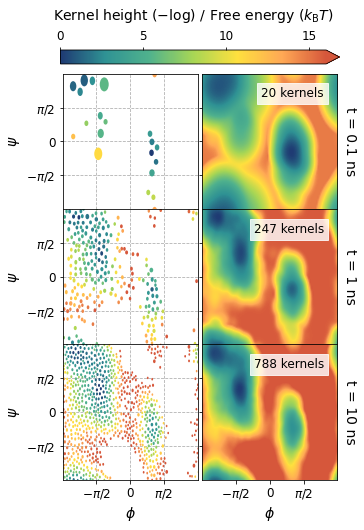

Method: explore


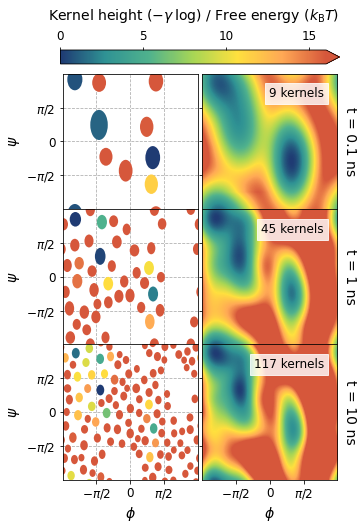

In [8]:
methods = ['opes', 'explore']
for method in methods:
    print('Method:',method)
    plot_figure(method)